# Fully Convolutional Neural Networks

Objectives:
- Load a CNN model pre-trained on ImageNet
- Transform the network into a Fully Convolutional Network 
- Apply the network perform weak segmentation on images

In [1]:
%matplotlib inline
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

In [2]:
# Load a pre-trained ResNet50
# We use include_top = False for now,
# as we'll import output Dense Layer later

from keras.applications.resnet50 import ResNet50
base_model = ResNet50(include_top=False)

print(base_model.output_shape)

Using TensorFlow backend.


(None, None, None, 2048)


In [3]:
# print(base_model.summary())

In [4]:
res5c = base_model.layers[-2]
type(res5c)

keras.layers.core.Activation

In [5]:
res5c.output_shape

(None, None, None, 2048)

In [6]:
avg_pool = base_model.layers[-1]
type(avg_pool)

keras.layers.pooling.AveragePooling2D

In [7]:
avg_pool.pool_size, avg_pool.strides

((7, 7), (7, 7))

In [8]:
avg_pool.output_shape

(None, None, None, 2048)

### Fully convolutional ResNet

- Out of the `res5c` residual block, the resnet outputs a tensor of shape $W \times H \times 2048$. 
- For the default ImageNet input, $224 \times 224$, the output size is $7 \times 7 \times 2048$
- After this bloc, the ResNet uses an average pooling `AveragePooling2D(pool_size=(7, 7))` with `(7, 7)` strides which divides by 7 the width and height

#### Regular ResNet layers 

The regular ResNet head after the base model is as follows: 
```py
x = base_model.output
x = Flatten()(x)
x = Dense(1000)(x)
x = Softmax()(x)
```

Here is the full definition of the model: https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py

#### Our Version

- To keep spatial information as much as possible, we will remove the average pooling.
- We want to retrieve the labels information, which is stored in the Dense layer. We will load these weights afterwards
- We will change the Dense Layer to a Convolution2D layer to keep spatial information, to output a $W \times H \times 1000$.
- We can use a kernel size of (1, 1) for that new Convolution2D layer to pass the spatial organization of the previous layer unchanged.
- We want to apply a softmax only on the last dimension so as to preserve the $W \times H$ spatial information.

#### A custom Softmax

We build the following Custom Layer to apply a softmax only to the last dimension of a tensor:

In [9]:
import keras
from keras.engine import Layer
import keras.backend as K

# A custom layer in Keras must implement the four following methods:
class SoftmaxMap(Layer):
    # Init function
    def __init__(self, axis=-1, **kwargs):
        self.axis = axis
        super(SoftmaxMap, self).__init__(**kwargs)

    # There's no parameter, so we don't need this one
    def build(self,input_shape):
        pass

    # This is the layer we're interested in: 
    # very similar to the regular softmax but note the additional
    # that we accept x.shape == (batch_size, w, h, n_classes)
    # which is not the case in Keras by default.
    def call(self, x, mask=None):
        e = K.exp(x - K.max(x, axis=self.axis, keepdims=True))
        s = K.sum(e, axis=self.axis, keepdims=True)
        return e / s

    # The output shape is the same as the input shape
    def get_output_shape_for(self, input_shape):
        return input_shape


Let's check that we can use this layer to normalize the classes probabilities of some random spatial predictions:

In [10]:
n_samples, w, h, n_classes = 10, 3, 4, 5
random_data = np.random.randn(n_samples, w, h, n_classes)
random_data.shape

(10, 3, 4, 5)

Because those predictions are random, if we some accross the classes dimensions we get random values instead of class probabilities that would need to some to 1:

In [11]:
random_data[0].sum(axis=-1)

array([[-2.71350777, -0.86746437, -2.75246579,  1.81204896],
       [ 0.20077116,  0.38639323, -1.20234259,  0.69994896],
       [-2.47878695,  0.32762955, -1.40622613,  0.12812544]])

Let's wrap the `SoftmaxMap` class into a test model to process our test data:

In [12]:
from keras.models import Sequential

model = Sequential([SoftmaxMap(input_shape=(w, h, n_classes))])
model.output_shape

(None, 3, 4, 5)

In [13]:
softmax_mapped_data = model.predict(random_data)
softmax_mapped_data.shape

(10, 3, 4, 5)

The last dimension now approximately sum to one, we can therefore be used as class probabilities (or parameters for a multinouli distribution):

In [14]:
softmax_mapped_data[0].sum(axis=-1)

array([[ 1.        ,  1.        ,  1.        ,  1.00000012],
       [ 1.        ,  0.99999988,  1.00000012,  0.99999994],
       [ 1.        ,  0.99999994,  0.99999994,  1.        ]], dtype=float32)

** Exercise **
- What is the shape of the convolution kernel we want to apply to replace the Dense ?
- Build the fully convolutional model as described above.
- You may introspect the last elements of `base_model.layers` to find which layer to remove
- You may use the Keras `Convolution2D(output_channels, filter_w, filter_h)` layer and our `SotfmaxMap` to normalize the result as per-class probabilities.

In [15]:
from keras.layers import Convolution2D
from keras.models import Model

input = base_model.layers[0].input

# TODO: compute per-area class probabilites
output = input

fully_conv_ResNet = Model(input=input, output=output)

In [16]:
# %load solutions/fully_conv.py
from keras.layers import Convolution2D
from keras.models import Model

input = base_model.layers[0].input

# Take the output of the layer just before the AveragePooling2D
# layer:
x = base_model.layers[-2].output

# A 1x1 convolution, with 1000 output channels, one per class
x = Convolution2D(1000, 1, 1, name='conv1000')(x)

# Softmax on last axis of tensor to normalize the class
# predictions in each spatial area
output = SoftmaxMap(axis=-1)(x)

fully_conv_ResNet = Model(input=input, output=output)

# A 1x1 convolution applies a Dense to each spatial grid location

You can use the following random data to check that it's possible to run a forward pass on a random RGB image:

In [17]:
prediction_maps = fully_conv_ResNet.predict(np.random.randn(1, 200, 300, 3))
prediction_maps.shape

(1, 7, 10, 1000)

How do you explain the resulting output shape?

The class probabilities should sum to one in each area of the output map:

In [18]:
prediction_maps.sum(axis=-1)

array([[[ 1.        ,  0.99999994,  1.        ,  0.99999988,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  0.99999994,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ,  0.99999994,
          1.        ,  1.00000012,  0.99999994,  1.        ,  1.        ],
        [ 1.        ,  0.99999988,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  0.99999988],
        [ 1.        ,  1.        ,  0.99999988,  0.99999988,  0.99999994,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  0.99999994,  0.99999994,  1.        ,  1.        ,
          1.        ,  1.        ,  1.00000012,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ,  0.99999994,
          0.99999988,  1.0000001

### Loading Dense weights

- We provide the weights and bias of the last Dense layer of ResNet50 in file `weights_dense.h5`
- Our last layer is now a 1x1 convolutional layer instead of a fully connected layer

In [19]:
import h5py
h5f = h5py.File('weights_dense.h5','r')
w = h5f['w'][:]
b = h5f['b'][:]
h5f.close()

In [20]:
last_layer = fully_conv_ResNet.layers[-2]

print("Loaded weight shape:", w.shape)
print("Last conv layer weights shape:", last_layer.get_weights()[0].shape)

Loaded weight shape: (2048, 1000)
Last conv layer weights shape: (1, 1, 2048, 1000)


In [21]:
# reshape the weights
w_reshaped = w.reshape((1, 1, 2048, 1000))

# set the conv layer weights
last_layer.set_weights([w_reshaped, b])

### A forward pass

- We define the following function to test our new network. 
- It resizes the input to a given size, then uses `model.predict` to compute the output

In [22]:
from scipy.misc import imread, imresize
from keras.applications.imagenet_utils import preprocess_input

def forward_pass_resize(img_path, img_size):
    img_raw = imread(img_path)
    print("img shape before resizing: %s" % (img_raw.shape,))
    img = imresize(img_raw, size=img_size).astype("float32")
    img = preprocess_input(img[np.newaxis])
    print("img batch size shape before forward pass:", img.shape)
    z = fully_conv_ResNet.predict(img)
    return z

In [23]:
output = forward_pass_resize("dog.jpg", (800, 600))
print("prediction map shape", output.shape)

img shape before resizing: (1600, 2560, 3)
img batch size shape before forward pass: (1, 800, 600, 3)
prediction map shape (1, 25, 19, 1000)


### Finding dog-related classes
ImageNet uses an ontology of concepts, from which classes are derived. A synset corresponds to a node in the ontology.

For example species of dogs are children nodes of the synset `dog`

In [24]:
# Helper file for importing synsets from imagenet
import imagenet_tool
synset = "n02084071" # synset corresponding to dogs
ids = imagenet_tool.synset_to_dfs_ids(synset)
print("All dog classes ids (%d):" % len(ids))
print(ids)

All dog classes ids (118):
[251, 268, 256, 253, 255, 254, 257, 159, 211, 210, 212, 214, 213, 216, 215, 219, 220, 221, 217, 218, 207, 209, 206, 205, 208, 193, 202, 194, 191, 204, 187, 203, 185, 192, 183, 199, 195, 181, 184, 201, 186, 200, 182, 188, 189, 190, 197, 196, 198, 179, 180, 177, 178, 175, 163, 174, 176, 160, 162, 161, 164, 168, 173, 170, 169, 165, 166, 167, 172, 171, 264, 263, 266, 265, 267, 262, 246, 242, 243, 248, 247, 229, 233, 234, 228, 231, 232, 230, 227, 226, 235, 225, 224, 223, 222, 236, 252, 237, 250, 249, 241, 239, 238, 240, 244, 245, 259, 261, 260, 258, 154, 153, 158, 152, 155, 151, 157, 156]


In [25]:
for dog_id in ids[:10]:
    print(imagenet_tool.id_to_words(dog_id))
print('...')

dalmatian, coach dog, carriage dog
Mexican hairless
Newfoundland, Newfoundland dog
basenji
Leonberg
pug, pug-dog
Great Pyrenees
Rhodesian ridgeback
vizsla, Hungarian pointer
German short-haired pointer
...


### Unsupervised heatmap of the class "dog"

The following function builds a heatmap from a forward pass. It sums the representation for all ids corresponding to a synset

In [26]:
def build_heatmap(z, synset):
    ids = imagenet_tool.synset_to_dfs_ids(synset)
    ids = np.array([id_ for id_ in ids if id_ is not None])
    x = z[0, :, :, ids].sum(axis=0)
    print("size of heatmap: " + str(x.shape))
    return x

In [27]:
def display_img_and_heatmap(img_path, heatmap):
    dog = imread(img_path)
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(dog)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, interpolation='nearest', cmap="viridis")
    plt.axis('off')

**Exercise**
- What is the size of the heatmap compared to the input image?
- Build 3 dog heatmaps from `"dog.jpg"`, with the following sizes:
  - `(400, 640)`
  - `(800, 1280)`
  - `(1600, 2560)`
- What do you observe? 

You may plot a heatmap using the above function `display_img_and_heatmap`

In [28]:
# dog synset
s = "n02084071"

# TODO

img shape before resizing: (1600, 2560, 3)
img batch size shape before forward pass: (1, 400, 640, 3)
size of heatmap: (13, 20)
img shape before resizing: (1600, 2560, 3)
img batch size shape before forward pass: (1, 800, 1280, 3)
size of heatmap: (25, 40)
img shape before resizing: (1600, 2560, 3)
img batch size shape before forward pass: (1, 1600, 2560, 3)
size of heatmap: (50, 80)


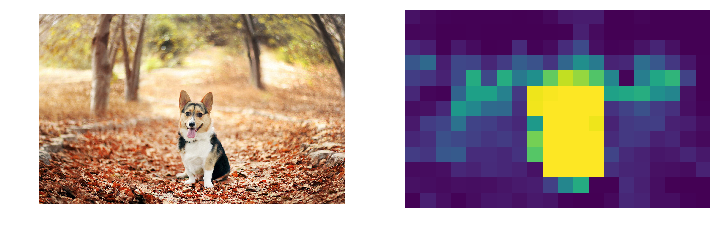

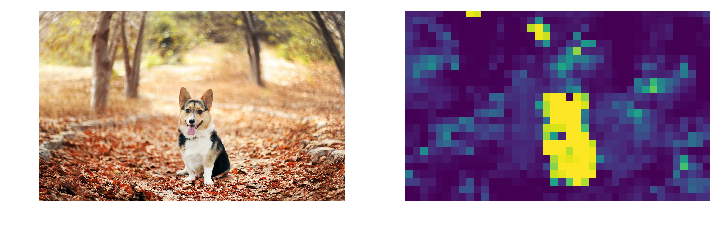

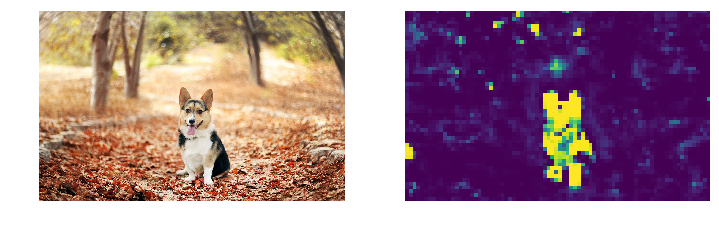

In [29]:
# %load solutions/build_heatmaps.py
s = "n02084071"

probas_1 = forward_pass_resize("dog.jpg", (400, 640))
heatmap_1 = build_heatmap(probas_1, synset=s)
display_img_and_heatmap("dog.jpg", heatmap_1)

probas_2 = forward_pass_resize("dog.jpg", (800, 1280))
heatmap_2 = build_heatmap(probas_2, synset=s)
display_img_and_heatmap("dog.jpg", heatmap_2)

probas_3 = forward_pass_resize("dog.jpg", (1600, 2560))
heatmap_3 = build_heatmap(probas_3, synset=s)
display_img_and_heatmap("dog.jpg", heatmap_3)

# We observe that heatmap_1 and heatmap_2 gave coarser 
# segmentations than heatmap_3. However, heatmap_3
# has small artifacts outside of the dog area
# heatmap_3 encodes more local, texture level information
# about the dog, while lower resolutions will encode more
# semantic information about the full object
# combining them is probably a good idea!

### Combining the 3 heatmaps
By combining the heatmaps at different scales, we obtain a much better information about the location of the dog.

**Bonus**
- Combine the three heatmap by resizing them to a similar shape, and averaging them
- A geometric norm will work better than standard average!

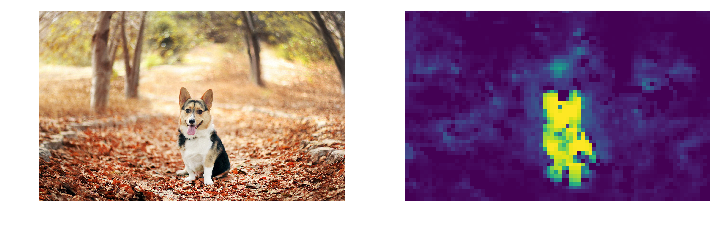

In [30]:
# %load solutions/geom_avg.py
heatmap_1_r = imresize(heatmap_1, (50,80)).astype("float32")
heatmap_2_r = imresize(heatmap_2, (50,80)).astype("float32")
heatmap_3_r = imresize(heatmap_3, (50,80)).astype("float32")

heatmap_geom_avg = np.power(heatmap_1_r * heatmap_2_r * heatmap_3_r, 0.333)
display_img_and_heatmap("dog.jpg", heatmap_geom_avg)


**Bonus**

Train the parameters of the last Convolution / classification layer of this segmentation network on classes of your choice on the MS COCO 2016 dataset:

http://mscoco.org/dataset/#overview

- Use the GPU to precompute the activations of a headless and convolutionalized ResNet50 or Xception model;
- Initialize the weights of a new Convolution2D(n_classes, 1, 1) at random;
- Train the top of the segmentation model on class label data extracted from the  MS COCO 2016 dataset;
- Start with a single low resolution model. Then add multi-scale and see the improvement.